In [13]:
import pandas as pd
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.datasets import fetch_california_housing

from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy import stats

In [14]:
# Load the California Housing dataset
housing = fetch_california_housing(as_frame=True)


df = pd.DataFrame(data=housing.data, columns=housing.feature_names)
df["target"] = housing.target

df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
df = df.reset_index(drop=True)
X = df[housing.feature_names]
targets = df["target"]
# Always use transform_data function on X
scaler = StandardScaler().fit(np.array(targets).reshape(-1, 1))
targets = scaler.transform(np.array(targets).reshape(-1, 1)).flatten()

df["target"] = targets
data=df

In [15]:
import sys
sys.path.append('..')
from xDL.models.NAM import NAM

In [16]:
from xDL import ShapeFunctionRegistry
from xDL.shapefuncs.baseshapefunction import ShapeFunction

class MyCustomFunction(ShapeFunction):

    def __init__(self, inputs, *args, **kwargs):

        super(MyCustomFunction, self).__init__(*args, **kwargs)

        self.arch = [tf.keras.layers.Dense(self.my_hyperparam, activation=self.my_activation)]
        self.arch.append(tf.keras.layers.Dense(self.my_hyperparam, activation="tanh"))
        self.arch.append(tf.keras.layers.Dense(1, activation="linear", use_bias=False))

    def forward(self, inputs):
        x = inputs
        for layer in self.arch:
            x = layer(x)

        return x
    

ShapeFunctionRegistry.add_class("MyCustomFunction", MyCustomFunction)

In [17]:
nam = NAM(
    "target ~  -1 + MLP(Longitude; encoding='PLE'; n_bins=15) + MyCustomFunction(Latitude; my_hyperparam=10; my_activation='relu') + RandomFourierNet(MedInc) + MLP(AveRooms; encoding=one_hot; n_bins=10; hidden_dims=[12, 12, 12]) + ResNet(AveOccup) + MLP(AveBedrms) + MyCustomFunction(Population; my_hyperparam=10; my_activation='tanh')", 
    data=data, 
    feature_dropout=0.0001
    )

--- Preprocessing ---


0it [00:00, ?it/s]

8it [00:22,  2.83s/it]
7it [00:00,  7.41it/s]


------------- Network architecture --------------
Longitude -> MLP(feature=Longitude, n_params=14528) -> output dimension=1
Latitude -> MyCustomFunction(feature=Latitude, n_params=140) -> output dimension=1
MedInc -> RandomFourierNet(feature=MedInc, n_params=270465) -> output dimension=1
AveRooms -> MLP(feature=AveRooms, n_params=456) -> output dimension=1
AveOccup -> ResNet(feature=AveOccup, n_params=49920) -> output dimension=1
AveBedrms -> MLP(feature=AveBedrms, n_params=12736) -> output dimension=1
Population -> MyCustomFunction(feature=Population, n_params=140) -> output dimension=1


In [18]:
nam.compile(optimizer=Adam(learning_rate=0.001), loss="mean_squared_error", metrics="mse")

# Train the model
nam.fit(nam.training_dataset, epochs=25, validation_data=nam.validation_dataset)

# Evaluate the model
loss = nam.evaluate(nam.validation_dataset)
print("Test Loss:", loss)

Epoch 1/25
16/16 [==============================] - 6s 105ms/step - loss: 5.5980 - mse: 5.5980 - val_loss: 1.5983 - val_mse: 1.5983
Epoch 2/25
16/16 [==============================] - 1s 83ms/step - loss: 1.5547 - mse: 1.5547 - val_loss: 0.6285 - val_mse: 0.6285
Epoch 3/25
16/16 [==============================] - 1s 88ms/step - loss: 0.7635 - mse: 0.7635 - val_loss: 0.4361 - val_mse: 0.4361
Epoch 4/25
16/16 [==============================] - 1s 81ms/step - loss: 0.6274 - mse: 0.6274 - val_loss: 0.4525 - val_mse: 0.4525
Epoch 5/25
16/16 [==============================] - 1s 80ms/step - loss: 0.6061 - mse: 0.6061 - val_loss: 0.4963 - val_mse: 0.4963
Epoch 6/25
16/16 [==============================] - 1s 86ms/step - loss: 0.6735 - mse: 0.6735 - val_loss: 0.3967 - val_mse: 0.3967
Epoch 7/25
16/16 [==============================] - 1s 78ms/step - loss: 0.5570 - mse: 0.5570 - val_loss: 0.4283 - val_mse: 0.4283
Epoch 8/25
16/16 [==============================] - 1s 83ms/step - loss: 0.4931 - 

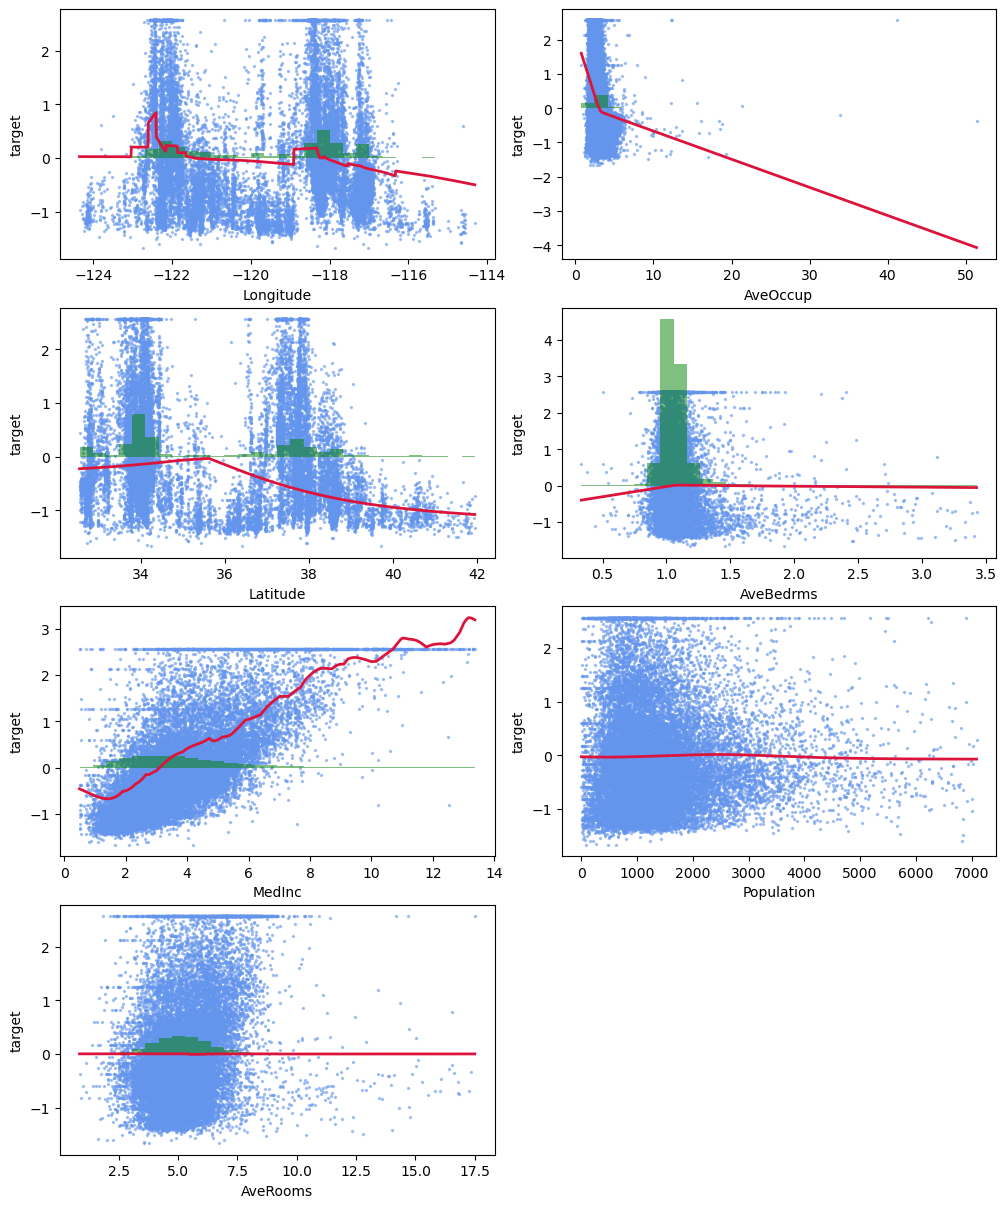

In [19]:
nam.plot()